In [1]:
%load_ext autoreload
%autoreload 2

I will try get explanations to the squared loss by modifying the default shap code through my local fork:

- Fork the shap package
- clone it from GitHub
- create a new conda environment
- install the package in editable mode

this works:

In [2]:
from shap.explainers import _tree

imported from folder


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Structure of the treeExplainer

- \_init\_(): 
  - creates a treeExplainer object:
  - self.model = TreeEnsemble (custom class):
    - attribute self.model_output, set to "raw" for RFR
    - attribute self.objective
    - method get_transform() -> this links to custom C++ classes. Here by default the RFR gets "identity". We want "squared_loss"
- shap_values():
  - gets transform = self.model.get_transform()
  - passes to c function _cext.dense_tree_shap(..., transform)

-> Initialising the get_transform() to "squared_loss" should do the trick?

For details of the changes I made to the shap package, check out the fork.



In [3]:
# build a toy model
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_diabetes

# Load the Diabetes dataset
diabetes = load_diabetes()

# create data
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# train a random forest model
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=0)
model.fit(X, y)
model.score(X, y)


0.4911965468843005

In [4]:
tE = _tree.TreeExplainer(model, data = X, model_output="squared_loss", feature_perturbation="interventional")

In [5]:
tE.model_output

'squared_loss'

I change the source code to override the transform argument that will be passed to the c function for shap computation.

In [6]:
tE.model.get_transform()

'squared_loss'

Let's try compute the shap values for this loss:

In [7]:
print(X.shape)

(442, 10)


In [9]:
tE.expected_value

26485.97396824045

In [11]:
model.predict(X).mean()**2

23167.55646157506

... not sure if this is the right ballpark...

In [13]:
# get reference value (mean prediction of model)

sv = tE.shap_values(X, y=y)
sv.shape

(442, 10)

So the code is running. Let's check if I get what I want. For this purpose I construct a super simple tree.

In [14]:
[1]*10 + [2]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [15]:
from sklearn.tree import DecisionTreeRegressor

x1 = [0]*10 + [1.0]*10
x2 = [1.0,0]*10
data = pd.DataFrame({"x1":x1, "x2":x2})
data["y"] = data.x1 + data.x2

data.head(20)

,x1,x2,y
0,0.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,1.0,1.0
3,0.0,0.0,0.0
4,0.0,1.0,1.0
5,0.0,0.0,0.0
6,0.0,1.0,1.0
7,0.0,0.0,0.0
8,0.0,1.0,1.0
9,0.0,0.0,0.0


In [16]:
# train Decision Tree with depth = 2
X = data[["x1", "x2"]]
y = data.y

simple_tree = DecisionTreeRegressor(max_depth=2)
simple_tree.fit(X = X, y = y)

simple_tree.score(X = X, y = y)

1.0

[Text(0.5, 0.8333333333333334, 'x2 <= 0.5\nsquared_error = 0.5\nsamples = 20\nvalue = 1.0'),
 Text(0.25, 0.5, 'x1 <= 0.5\nsquared_error = 0.25\nsamples = 10\nvalue = 0.5'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 0.0'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 1.0'),
 Text(0.75, 0.5, 'x1 <= 0.5\nsquared_error = 0.25\nsamples = 10\nvalue = 1.5'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 1.0'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 2.0')]

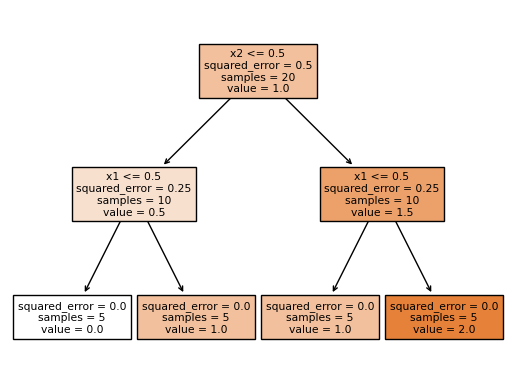

In [17]:
# visualize the tree

from sklearn.tree import plot_tree

plot_tree(simple_tree, feature_names=["x1", "x2"], filled=True)


Let's first initalize a TreeExplainer for the purpose of **prediction explanation**:

In [18]:
simple_tE = _tree.TreeExplainer(simple_tree, data = X, model_output="raw", feature_perturbation="interventional")

In [58]:
simple_tE.expected_value

1.0

In [19]:
simple_tE.model.get_transform()

'identity'

In [20]:
prediction_sv = simple_tE.shap_values(data[["x1", "x2"]])
prediction_sv.shape

(20, 2)

In [21]:
prediction_sv

array([[-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5]])

This all works correctly also in my modified shap code. Let's now try to compute the shap values for the squared deviation from the mean prediction:

In [72]:
simple_tE_dev = _tree.TreeExplainer(simple_tree, data = X, model_output="squared_loss", feature_perturbation="interventional")

In [101]:
simple_tE_dev.expected_value # expected value of the square! does not "subtract y", if y is not specified. and there is no way to specify y in the TreeExplainer...

1.5

In [53]:
simple_tree.predict(X)

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 2., 1., 2., 1., 2., 1., 2.,
       1., 2., 1.])

In [74]:
simple_tE_dev.model.predict(X,y = np.array([2]*20))

array([1., 4., 1., 4., 1., 4., 1., 4., 1., 4., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1.])

These values are correct for prediction of the transformed outcome! So this method works for getting the right expected value! (the _cext.dense_tree_predict() method).

In [82]:
true_exp_v = simple_tE_dev.model.predict(X,y = np.array([data.y.mean(0)]*20)).mean() # data.y.mean() = 1
true_exp_v

0.5

This will be the value to which the shap values have to be added to explain the total squared deviation.

In [75]:
simple_tE_dev.model.get_transform()

'squared_loss'

To compute the deviations, we need to pass our reference value in a vectorized fashion to the y argument:

In [93]:
# get reference vector
import numpy as np

ref = np.array([1]*20) # the ATE (average prediction)
ref

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [94]:
dev_sv = simple_tE_dev.shap_values(data[["x1", "x2"]], y=ref)
dev_sv.shape

(20, 2)

In [95]:
dev_sv

array([[-0.5 ,  0.  ],
       [ 0.25,  0.25],
       [-0.5 ,  0.  ],
       [ 0.25,  0.25],
       [-0.5 ,  0.  ],
       [ 0.25,  0.25],
       [-0.5 ,  0.  ],
       [ 0.25,  0.25],
       [-0.5 ,  0.  ],
       [ 0.25,  0.25],
       [ 0.25,  0.25],
       [ 0.  , -0.5 ],
       [ 0.25,  0.25],
       [ 0.  , -0.5 ],
       [ 0.25,  0.25],
       [ 0.  , -0.5 ],
       [ 0.25,  0.25],
       [ 0.  , -0.5 ],
       [ 0.25,  0.25],
       [ 0.  , -0.5 ]])

In [97]:
data["ref"] = ref
data["dev_sq"] = (data.y - data.ref)**2
data[["x1_shap_dev", "x2_shap_dev"]] = dev_sv
data["Exp_dev"] = 0.5
data["shap_implied_total"] = data.Exp_dev + data.x1_shap_dev + data.x2_shap_dev
data["check"] = (data.shap_implied_total == data.dev_sq)
data

,x1,x2,y,ref,dev_sq,x1_shap_dev,x2_shap_dev,Exp_dev,shap_implied_total,check
0,0.0,1.0,1.0,1,0.0,-0.50,0.00,0.5,0.0,True
1,0.0,0.0,0.0,1,1.0,0.25,0.25,0.5,1.0,True
2,0.0,1.0,1.0,1,0.0,-0.50,0.00,0.5,0.0,True
3,0.0,0.0,0.0,1,1.0,0.25,0.25,0.5,1.0,True
4,0.0,1.0,1.0,1,0.0,-0.50,0.00,0.5,0.0,True
5,0.0,0.0,0.0,1,1.0,0.25,0.25,0.5,1.0,True
6,0.0,1.0,1.0,1,0.0,-0.50,0.00,0.5,0.0,True
7,0.0,0.0,0.0,1,1.0,0.25,0.25,0.5,1.0,True
8,0.0,1.0,1.0,1,0.0,-0.50,0.00,0.5,0.0,True
9,0.0,0.0,0.0,1,1.0,0.25,0.25,0.5,1.0,True


Let's not try with messier data:

In [104]:
# draw x2 randomly from a normal distribution
x2 = np.random.normal(0,1,20)
data2 = pd.DataFrame({"x1":x1, "x2":x2})
data2["y"] = data2.x1 + data2.x2
data2

,x1,x2,y
0,0.0,0.976509,0.976509
1,0.0,-1.112258,-1.112258
2,0.0,1.183204,1.183204
3,0.0,1.780727,1.780727
4,0.0,0.206834,0.206834
5,0.0,0.521336,0.521336
6,0.0,1.493425,1.493425
7,0.0,-1.049948,-1.049948
8,0.0,-1.709292,-1.709292
9,0.0,0.585514,0.585514


In [105]:
# train another tree
simple_tree2 = DecisionTreeRegressor(max_depth=2)
simple_tree2.fit(X = data2[["x1", "x2"]], y = data2.y)
simple_tree2.score(X = data2[["x1", "x2"]], y = data2.y)

0.8709321299122345

[Text(0.5, 0.8333333333333334, 'x2 <= -0.877\nsquared_error = 1.007\nsamples = 20\nvalue = 0.553'),
 Text(0.25, 0.5, 'x1 <= 0.5\nsquared_error = 0.264\nsamples = 5\nvalue = -0.931'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.088\nsamples = 3\nvalue = -1.29'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.044\nsamples = 2\nvalue = -0.392'),
 Text(0.75, 0.5, 'x2 <= 0.548\nsquared_error = 0.275\nsamples = 15\nvalue = 1.048'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.139\nsamples = 7\nvalue = 0.67'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.159\nsamples = 8\nvalue = 1.379')]

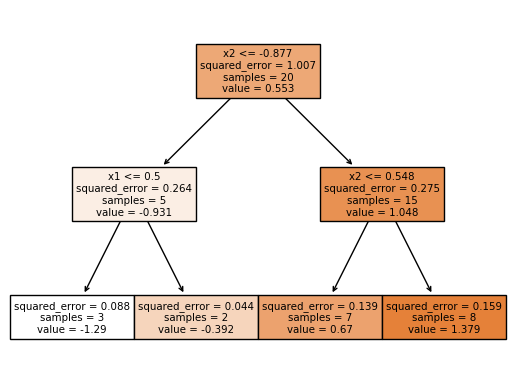

In [106]:
# visualize the tree

plot_tree(simple_tree2, feature_names=["x1", "x2"], filled=True)

In [107]:
simple_tE2_dev = _tree.TreeExplainer(simple_tree2, data = data2[["x1","x2"]], model_output="squared_loss", feature_perturbation="interventional")

In [108]:
# get the mean prediction
data2["pred"] = simple_tree2.predict(data2[["x1", "x2"]])
data2["ref"] = data2.pred.mean()
data2

,x1,x2,y,pred,ref
0,0.0,0.976509,0.976509,1.379185,0.553467
1,0.0,-1.112258,-1.112258,-1.290499,0.553467
2,0.0,1.183204,1.183204,1.379185,0.553467
3,0.0,1.780727,1.780727,1.379185,0.553467
4,0.0,0.206834,0.206834,0.670143,0.553467
5,0.0,0.521336,0.521336,0.670143,0.553467
6,0.0,1.493425,1.493425,1.379185,0.553467
7,0.0,-1.049948,-1.049948,-1.290499,0.553467
8,0.0,-1.709292,-1.709292,-1.290499,0.553467
9,0.0,0.585514,0.585514,1.379185,0.553467


In [111]:
# get the expected value of the explainable deviation
mean_pred = simple_tE2_dev.model.predict(data2[["x1","x2"]], y = data2.ref).mean()
mean_pred

0.8768774674396314

In [113]:
sv_dev2 = simple_tE2_dev.shap_values(data2[["x1", "x2"]], y = data2.ref)
sv_dev2.shape

(20, 2)

In [116]:
# add to data
data2[['x1_shap_dev', 'x2_shap_dev']] = sv_dev2
data2["implied_total"] = data2.x1_shap_dev + data2.x2_shap_dev + mean_pred
data2["dev"] = (data2.pred - data2.ref)**2
data2["check"] = np.isclose(data2.dev, data2.implied_total)
data2

,x1,x2,y,pred,ref,x1_shap_dev,x2_shap_dev,implied_total,dev,check
0,0.0,0.976509,0.976509,1.379185,0.553467,0.005373,-0.200440,0.681810,0.681810,True
1,0.0,-1.112258,-1.112258,-1.290499,0.553467,0.513329,2.010004,3.400211,3.400211,True
2,0.0,1.183204,1.183204,1.379185,0.553467,0.005373,-0.200440,0.681810,0.681810,True
3,0.0,1.780727,1.780727,1.379185,0.553467,0.005373,-0.200440,0.681810,0.681810,True
4,0.0,0.206834,0.206834,0.670143,0.553467,0.037233,-0.900497,0.013613,0.013613,True
5,0.0,0.521336,0.521336,0.670143,0.553467,0.037233,-0.900497,0.013613,0.013613,True
6,0.0,1.493425,1.493425,1.379185,0.553467,0.005373,-0.200440,0.681810,0.681810,True
7,0.0,-1.049948,-1.049948,-1.290499,0.553467,0.513329,2.010004,3.400211,3.400211,True
8,0.0,-1.709292,-1.709292,-1.290499,0.553467,0.513329,2.010004,3.400211,3.400211,True
9,0.0,0.585514,0.585514,1.379185,0.553467,0.005373,-0.200440,0.681810,0.681810,True


IT WORKS!!!!